# Rainfall maps from CML data and merging with radar data
___
<img src="https://hess.copernicus.org/articles/24/2931/2020/hess-24-2931-2020-f07-web.png" alt="drawing" width="800"/>

Accumulated rainfall for a 48 hour show case from 12 to 14 May 2018 for a) RADOLAN-RW, a gauge ajdusted radar product from the German Weaterh Service and b) CML derived rainfall interpolated using inverse distance weighting [Graf et al. 2020](https://hess.copernicus.org/articles/24/2931/2020/).     

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('pycomlink/src')
sys.path.append('poligrain/src')
import xarray as xr
import pycomlink as pycml
import pycomlink.pycomlink.spatial as spatial
import poligrain as plg
import matplotlib.pyplot as plt
import numpy as np
import tqdm

## 1. Process many CMLs

In [2]:
ds_cml = xr.open_dataset('example_data/openmrg_cml_5min_2h.nc')

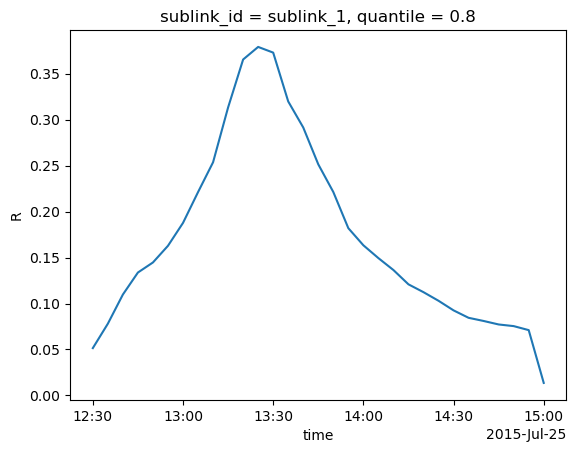

In [37]:
# check mean cml rainfall
ds_cml.R.mean(dim='cml_id').plot()

# 2. Interpolate rainfall maps

In [4]:
# beware: 
# - the lat and lon coordinates should be converted to UTM (we skip this part)
# - using the link midpoint is an approximation, more advanced teqniques exists. 

<img src="https://gisgeography.com/wp-content/uploads/2016/05/IDW-3Points.png" alt="drawing" width="600"/>


In [5]:
# define timestep 
time = '2015-07-25 13:25'
# load radar reference data
radar_ref = xr.open_dataset('example_data/openmrg_rad_5min_2h.nc')

# get the center of each CML
ds_cml["lat_center"] = (ds_cml.site_0_lat + ds_cml.site_1_lat) / 2
ds_cml["lon_center"] = (ds_cml.site_0_lon + ds_cml.site_1_lon) / 2

### 5.1 Inverse distance weighting (IDW)

In [6]:
# define the properties of the IDW algorithm
idw_interpolator = spatial.interpolator.IdwKdtreeInterpolator(
    nnear=15,  # <------------- number of neighbors
    p=2,  # <------------------ weighting parameter
    exclude_nan=True,  # <----- remove nan values from interpolation
    max_distance=0.4,  # <----- upper bound distance
)

In [7]:
# interpolate one hour of rainfall using the lat and lon of the link midpoint. 
R_grid_idw = idw_interpolator(
    x=ds_cml.lon_center,  # <------------------------- input x coordinates
    y=ds_cml.lat_center,  # <------------------------- input y coordinates
    z=ds_cml.R.sel(time=time),  # <----- rainfall values
    xgrid=radar_ref.longitudes.values,  # <--------- target grid x coordinates
    ygrid=radar_ref.latitudes.values,  # <--------- target grid y coordinates
)

In [8]:
radar_ref['R_grid_idw'] = (('y', 'x'), R_grid_idw)

### 5.2 Ordinary Kriging

In [9]:
kriging_interpolator = spatial.interpolator.OrdinaryKrigingInterpolator(
    nlags=6,
    variogram_model='spherical',
    #variogram_parameters=None,
    weight=True,
    n_closest_points=15,
)

In [10]:
R_grid_kriging = kriging_interpolator(
    x=ds_cml.lon_center.where(~np.isnan(ds_cml.R.sel(time=time)), drop = True), 
    y=ds_cml.lat_center.where(~np.isnan(ds_cml.R.sel(time=time)), drop = True), 
    z=ds_cml.R.sel(time=time).where(~np.isnan(ds_cml.R.sel(time=time)), drop = True),  # <----- rainfall values
    xgrid=radar_ref.longitudes.values,  # <--------- target grid x coordinates
    ygrid=radar_ref.latitudes.values,  # <--------- target grid y coordinates
)

In [11]:
radar_ref['R_grid_kriging'] = (('y', 'x'), R_grid_kriging)

### Plot IDW and Kriging results

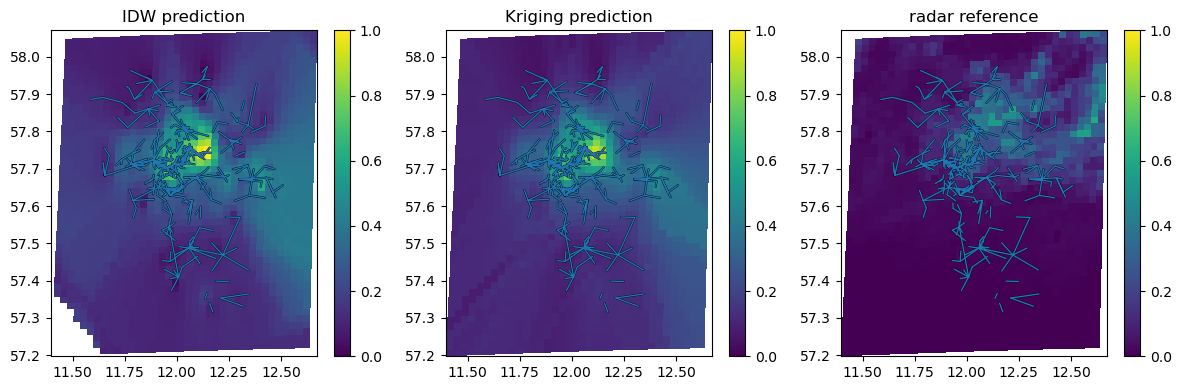

In [24]:
# such a 2-d array can be visulaized with matplotlibs pcolormesh function
fig, ax = plt.subplots(1, 3, figsize = (4*3, 4))

ax[0].set_title('IDW prediction')
im=ax[0].pcolormesh(radar_ref.longitudes.values, radar_ref.latitudes.values, R_grid_idw,vmin=0,vmax=1)
plg.plot_map.plot_lines(ds_cml, use_lon_lat=True, ax=ax[0]) 
plt.colorbar(im, ax=ax[0])

ax[1].set_title('Kriging prediction')
im = ax[1].pcolormesh(radar_ref.longitudes.values, radar_ref.latitudes.values, radar_ref['R_grid_kriging'],vmin=0,vmax=1)
plg.plot_map.plot_lines(ds_cml, use_lon_lat=True, ax=ax[1])
plt.colorbar(im, ax=ax[1])   

ax[2].set_title('radar reference')
im = ax[2].pcolormesh(
    radar_ref.longitudes.values, 
    radar_ref.latitudes.values, 
    radar_ref.rainfall_amount.sel(time = time, method = 'nearest'),vmin=0,vmax=1
)
plg.plot_map.plot_lines(ds_cml, use_lon_lat=True, ax=ax[2])
plt.colorbar(im, ax=ax[2])
plt.tight_layout();


# Comparing IDW and Kriging to the radar reference

In [25]:
# crop the radar and estimated rainfall fields so that we compare the interpolated pixels
radar_ref_crop = radar_ref.isel(x = slice(10, 30), y = slice(10, 40))

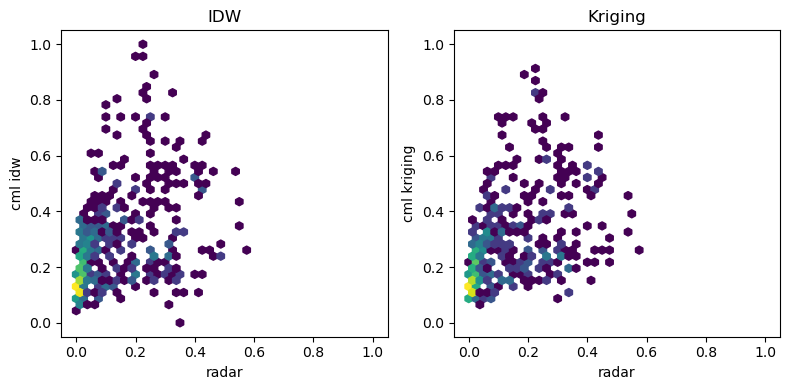

In [36]:
fig, ax = plt.subplots(1, 2, figsize= (8, 4))
ax[0].hexbin(
    radar_ref_crop.rainfall_amount.sel(time = time, method = 'nearest').values,
    radar_ref_crop.R_grid_idw.values,
    bins = 'log',
    gridsize = 40,
    extent = (0, 1, 0, 1),
    mincnt=1,
)
ax[0].set_title('IDW')
ax[0].set_xlabel('radar')
ax[0].set_ylabel('cml idw')

ax[1].hexbin(
    radar_ref_crop.rainfall_amount.sel(time = time, method = 'nearest').values,
    radar_ref_crop.R_grid_kriging.values,
    bins = 'log',
    gridsize = 40,
    extent = (0, 1, 0, 1),
    mincnt=1,
)
ax[1].set_title('Kriging');
ax[1].set_xlabel('radar')
ax[1].set_ylabel('cml kriging')
plt.tight_layout();

# Exercises:

#### Exercise 1
Interpolate and plot the rainfall sum of the 2.5 example dataset and compare it to the reference

In [68]:
ds_cml_sum = ds_cml.sum(dim='time')
radar_ref_sum = radar_ref.sum(dim='time')

# interpolate one hour of rainfall using the lat and lon of the link midpoint. 
R_grid_idw = idw_interpolator(
    x=ds_cml_sum.lon_center,  # <------------------------- input x coordinates
    y=ds_cml_sum.lat_center,  # <------------------------- input y coordinates
    z=ds_cml_sum.R,  # <----- rainfall values
    xgrid=radar_ref.longitudes.values,  # <--------- target grid x coordinates
    ygrid=radar_ref.latitudes.values,  # <--------- target grid y coordinates
)

radar_ref_sum['R_grid_idw'] = (('y', 'x'), R_grid_idw)

R_grid_kriging = kriging_interpolator(
    x=ds_cml_sum.lon_center, 
    y=ds_cml_sum.lat_center, 
    z=ds_cml_sum.R,  # <----- rainfall values
    xgrid=radar_ref.longitudes.values,  # <--------- target grid x coordinates
    ygrid=radar_ref.latitudes.values,  # <--------- target grid y coordinates
)

radar_ref_sum['R_grid_kriging'] = (('y', 'x'), R_grid_kriging)

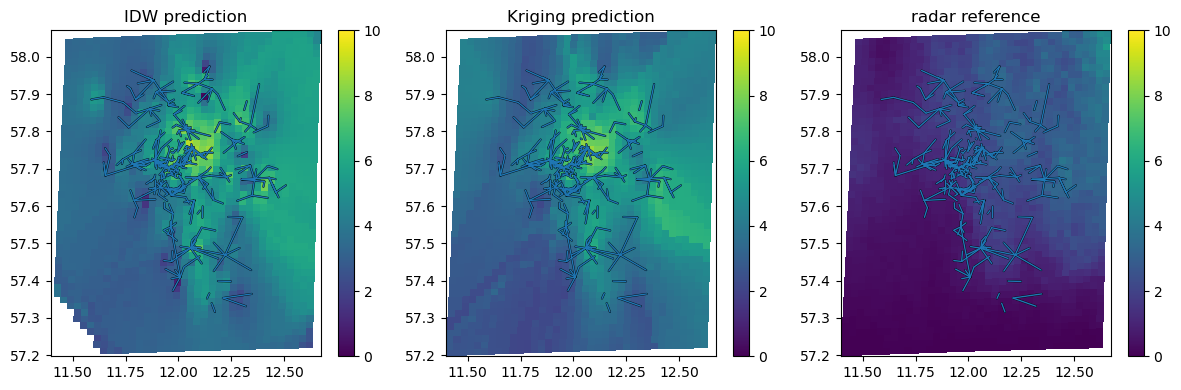

In [69]:
# such a 2-d array can be visulaized with matplotlibs pcolormesh function
fig, ax = plt.subplots(1, 3, figsize = (4*3, 4))

vmax=10

ax[0].set_title('IDW prediction')
im=ax[0].pcolormesh(radar_ref.longitudes.values, radar_ref.latitudes.values, R_grid_idw, vmin=0, vmax=vmax)
plg.plot_map.plot_lines(ds_cml, use_lon_lat=True, ax=ax[0]) 
plt.colorbar(im, ax=ax[0])

ax[1].set_title('Kriging prediction')
im = ax[1].pcolormesh(radar_ref.longitudes.values, radar_ref.latitudes.values, R_grid_kriging, vmin=0, vmax=vmax)
plg.plot_map.plot_lines(ds_cml, use_lon_lat=True, ax=ax[1])
plt.colorbar(im, ax=ax[1])   

ax[2].set_title('radar reference')
im = ax[2].pcolormesh(
    radar_ref_sum.longitudes.values, 
    radar_ref_sum.latitudes.values, 
    radar_ref_sum.rainfall_amount,vmin=0,vmax=vmax
)
plg.plot_map.plot_lines(ds_cml, use_lon_lat=True, ax=ax[2])
plt.colorbar(im, ax=ax[2])
plt.tight_layout();


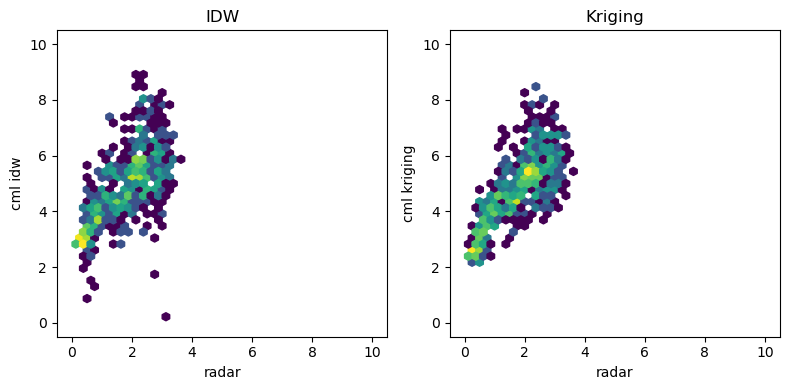

In [70]:
# crop the radar and estimated rainfall fields so that we compare the interpolated pixels
radar_ref_crop = radar_ref_sum.isel(x = slice(10, 30), y = slice(10, 40))

fig, ax = plt.subplots(1, 2, figsize= (8, 4))
ax[0].hexbin(
    radar_ref_crop.rainfall_amount.values,
    radar_ref_crop.R_grid_idw.values,
    bins = 'log',
    gridsize = 40,
    extent = (0, 10, 0, 10),
    mincnt=1,
)
ax[0].set_title('IDW')
ax[0].set_xlabel('radar')
ax[0].set_ylabel('cml idw')

ax[1].hexbin(
    radar_ref_crop.rainfall_amount.values,
    radar_ref_crop.R_grid_kriging.values,
    bins = 'log',
    gridsize = 40,
    extent = (0, 10, 0, 10),
    mincnt=1,
)
ax[1].set_title('Kriging');
ax[1].set_xlabel('radar')
ax[1].set_ylabel('cml kriging')
plt.tight_layout();

#### Exercise 2


Interpolate all time steps and comapre the radar with the cml map... 

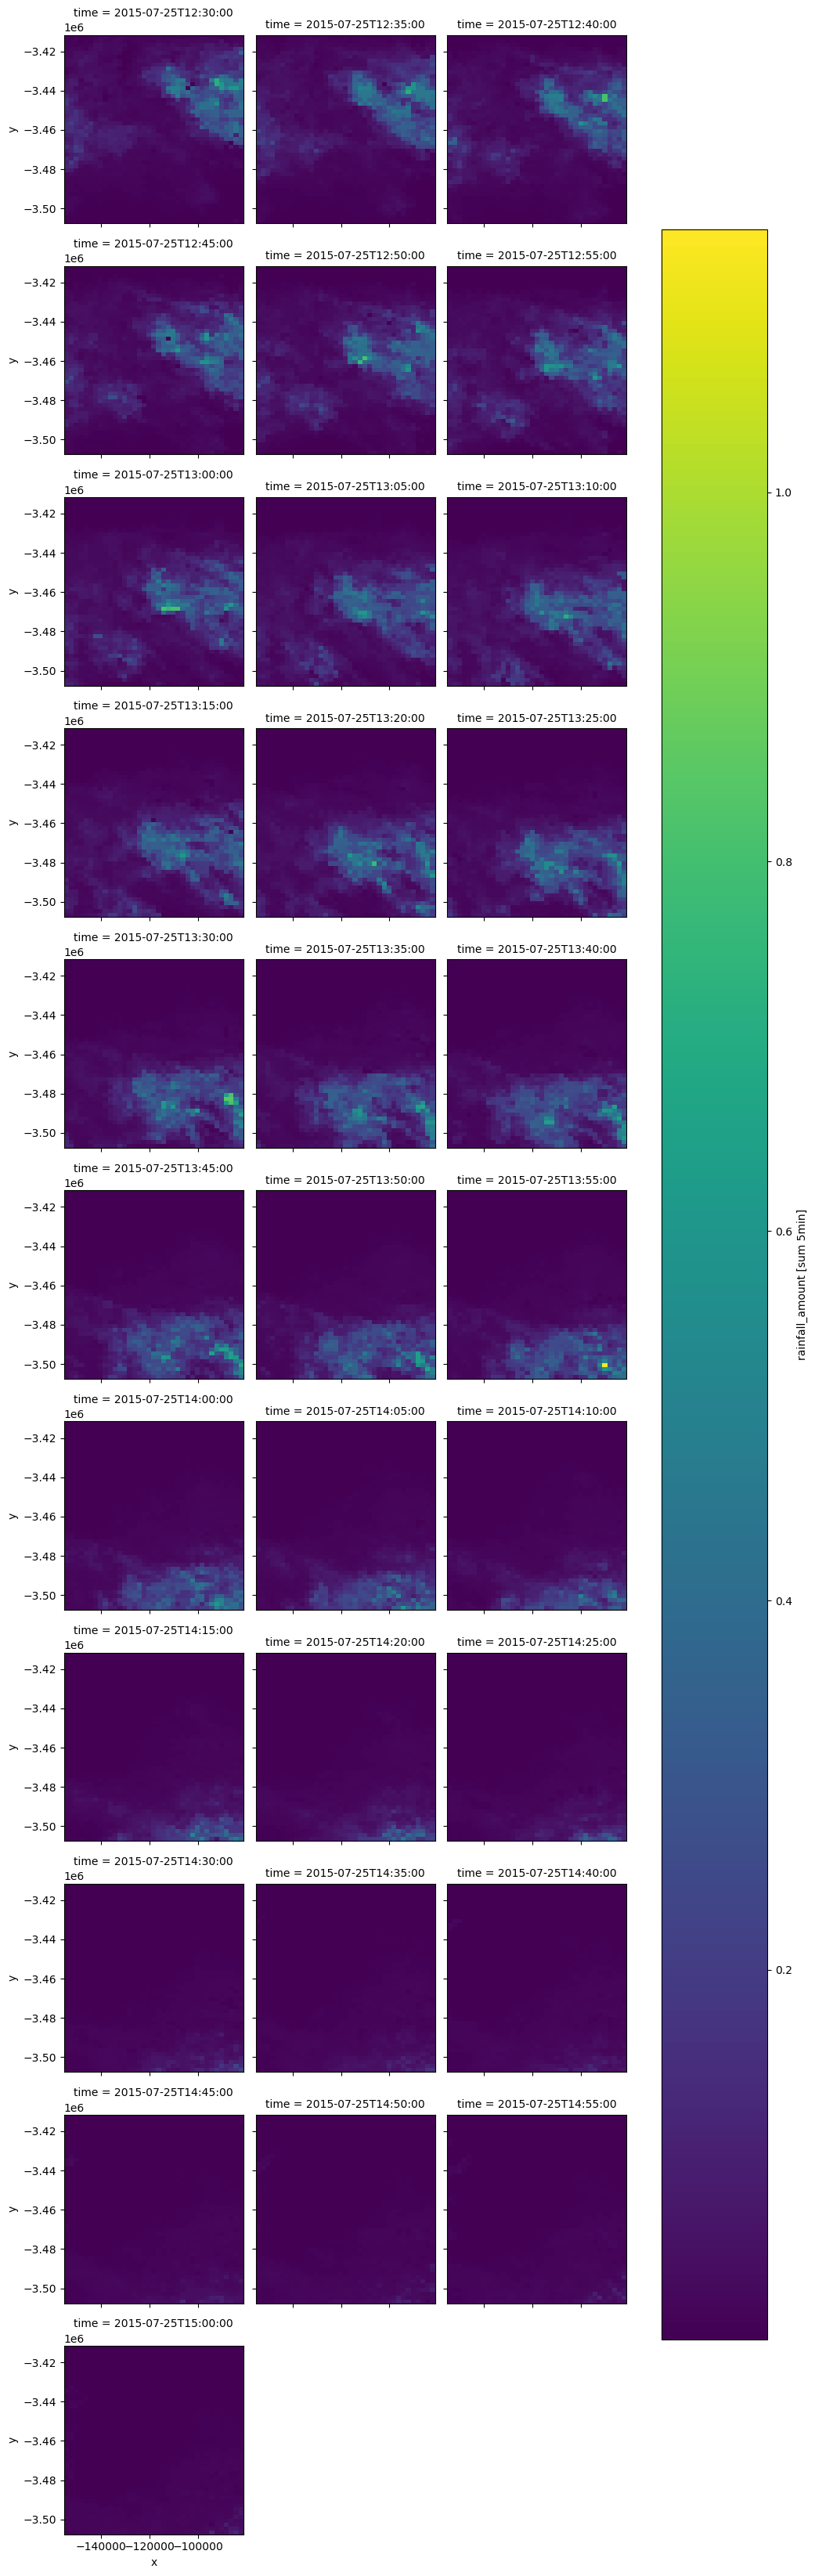

In [75]:
radar_ref.rainfall_amount.plot(x="x", y="y", col="time", col_wrap=3)